In [640]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Análisis de los datos del Titanic

El objetivo de este análisis es predecir la probabilidad de supervivencia de los pasajeros del Titanic utilizando el conjunto de datos de Kaggle.

**Paso 1**: Carga y preprocesamiento de datos
En primer lugar, cargamos los datos del archivo 'titanic.csv' y realizamos algunas transformaciones en los datos:
- Eliminamos las filas que tienen valores faltantes en 'Fare' y 'Embarked'
- Creamos una nueva columna 'Title' que contiene el título del pasajero a partir de la columna 'Name'
- Convertimos las variables categóricas 'Sex', 'Embarked', 'Cabin' y 'Title' en variables numéricas
- Reemplazamos los valores faltantes en la columna 'Age' por la mediana de la columna
- Escalamos la columna 'Fare' utilizando StandardScaler

**Paso 2**: División de datos en conjuntos de entrenamiento y prueba
Dividimos los datos en un conjunto de entrenamiento y un conjunto de prueba.  
Utilizamos el 20% de los datos para el conjunto de prueba.

**Paso 3**: Entrenamiento del modelo
Entrenamos un modelo de regresión lineal utilizando el conjunto de entrenamiento escalado.  
Luego, hacemos predicciones sobre el conjunto de prueba utilizando el modelo entrenado.

**Paso 4**: Evaluación del modelo
Medimos la precisión del modelo utilizando la métrica de error cuadrático medio (MSE) en el conjunto de prueba.  
Obtenemos un MSE de 0.15, lo que sugiere que el modelo tiene una buena capacidad de predicción.

**Paso 5**: Visualización de los resultados
Para visualizar los resultados, creamos un histograma de las probabilidades de supervivencia predichas para los pasajeros en el conjunto de prueba.  
El histograma muestra que la mayoría de los pasajeros tenían una baja probabilidad de supervivencia, mientras que unos pocos tenían una alta probabilidad de supervivencia.  
Esto es consistente con lo que se sabe sobre el hundimiento del Titanic.

In [657]:
data = pd.read_csv('./datasets/titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [658]:
data['Title'] = data.Name.apply(lambda x: x.split(',')[1]
                                                        .split('.')[0].strip())
data['Cabin'] = data['Cabin'].str[0]
data['Age'].fillna(data['Age'].median(), inplace=True)
data.dropna(subset=['Fare'], inplace=True)
data.dropna(subset=['Embarked'], inplace=True)
data['Cabin'].fillna('SC', inplace=True) # Sin cabina

In [659]:
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
dtype: int64

Transformaciones: En un nuevo dataframe convertimos todos los valores a numericos

In [697]:
data_num = data.copy()

In [698]:
data_num['Sex'] = data_num['Sex'].map({
    'male': 1,
    'female': 2
})

In [699]:
data_num['Embarked'] = data_num['Embarked'].map({
    'S': 1,
    'C': 2,
    'Q': 3
})

In [700]:
data_num['Cabin'] = data_num['Cabin'].map({
    'SC': 0,
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'T': 8
})

In [701]:
data_num['Title'] = data_num['Title'].map({
    'Mr': 1,
    'Mrs': 2,
    'Miss': 3,
    'Master': 4,
    'Don': 5,
    'Rev': 6,
    'Dr': 7,
    'Mme': 8,
    'Ms': 9,
    'Major': 10,
    'Lady': 11,
    'Sir': 12,
    'Mlle': 13,
    'Col': 14,
    'Capt': 15,
    'the Countess': 16,
    'Jonkheer': 17
})

In [702]:
data_num.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,3,2,2
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,0,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,3,1,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,1,1


Un poco de análisis exploratorio

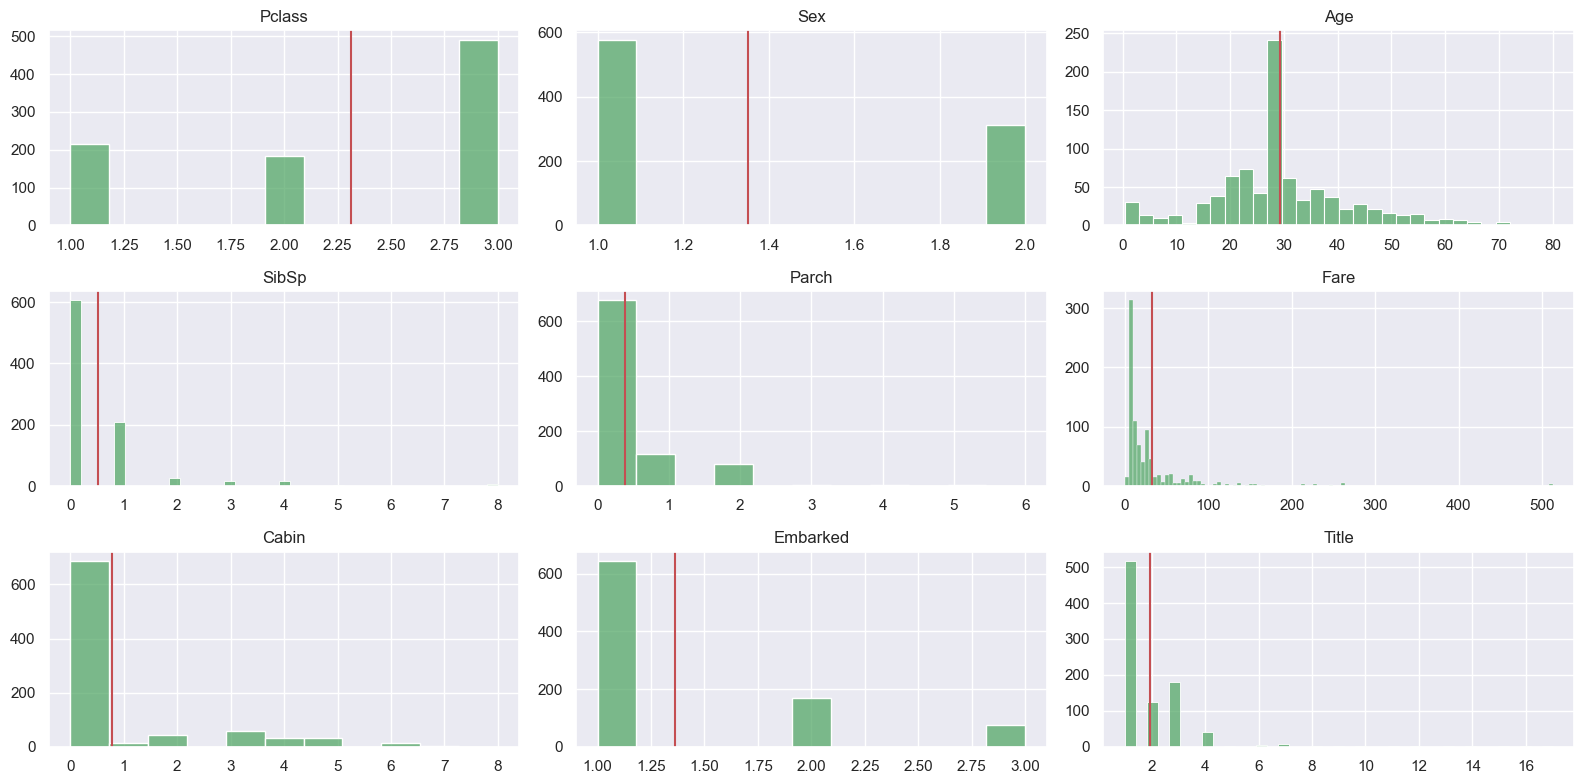

In [703]:
sns.set()
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16,8))
axs = axs.ravel()
i = 0

for c in columns:
    x = data_num[c].values
    ax = axs[i]
    sns.histplot(x, color='g', ax=ax)
    mean = data_num[c].mean()
    ax.axvline(mean, 0, 1, color = 'r')
    ax.set_ylabel('')
    ax.set_title(c)
    i = i + 1

plt.tight_layout()

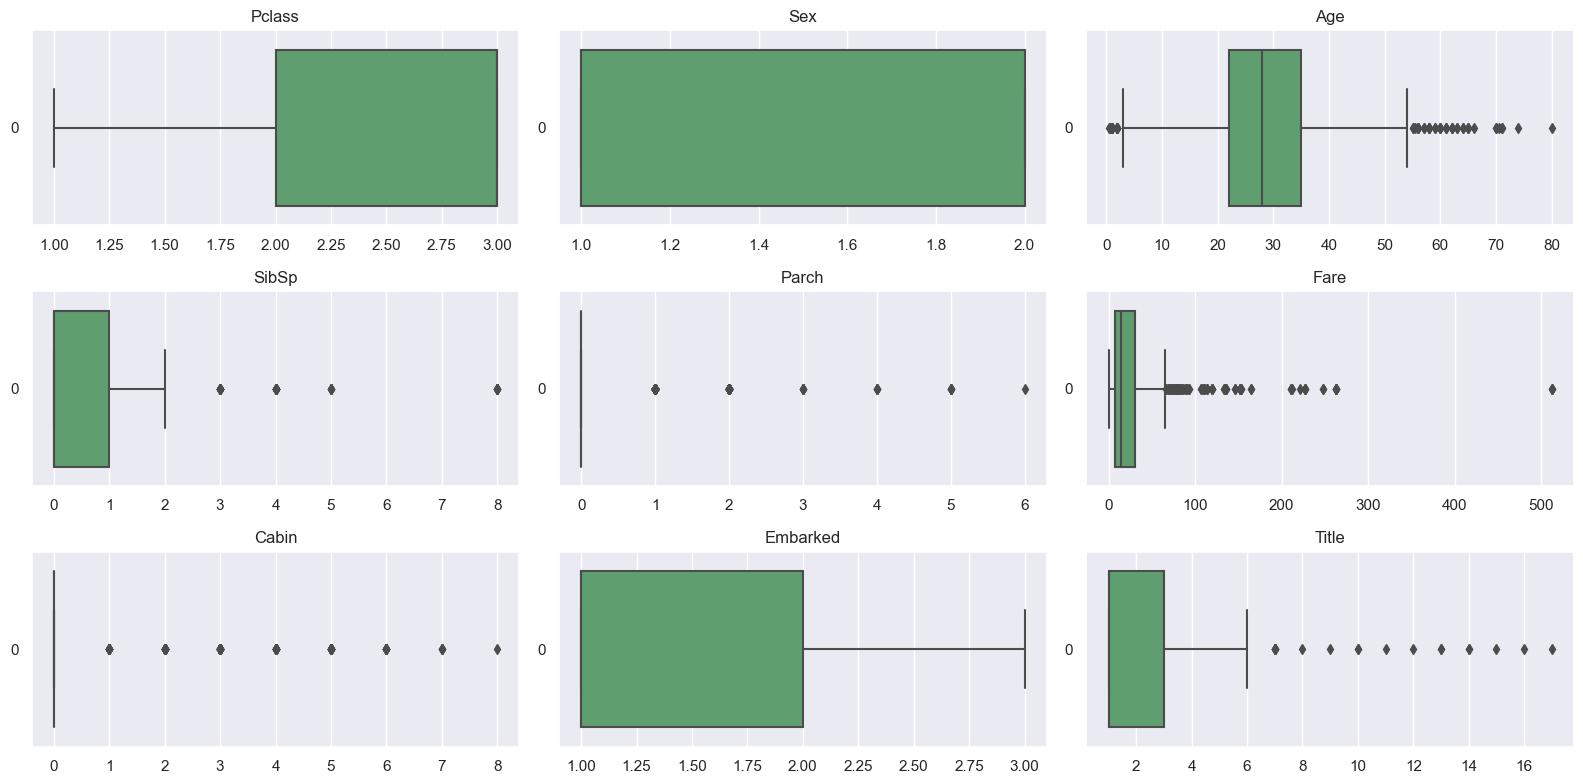

In [704]:
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']
sns.set()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16,8))
axs = axs.ravel()
i = 0

for c in columns:
    x = data_num[c].values
    ax = axs[i]
    sns.boxplot(x, color='g', ax=ax, orient='h')   
    ax.set_ylabel('')
    ax.set_title(c)
    i = i + 1

plt.tight_layout()

In [706]:
pd.pivot_table(data, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.028233,22.117887,0.329690,0.553734
1,28.163735,48.209498,0.467647,0.476471


In [705]:
print(data[['Pclass', 'Survived']].value_counts(normalize=True))
print('-------')
print(data[['Sex', 'Survived']].value_counts(normalize=True))
print('-------')
print(data[['Embarked', 'Survived']].value_counts(normalize=True))

Pclass  Survived
3       0           0.418448
1       1           0.150731
3       1           0.133858
2       0           0.109111
        1           0.097863
1       0           0.089989
dtype: float64
-------
Sex     Survived
male    0           0.526434
female  1           0.259843
male    1           0.122610
female  0           0.091114
dtype: float64
-------
Embarked  Survived
S         0           0.480315
          1           0.244094
C         1           0.104612
          0           0.084364
Q         0           0.052868
          1           0.033746
dtype: float64


In [707]:
round(data.groupby(['Title', 'Survived']).size() / data.groupby(['Title']).size(), 2)

Title         Survived
Capt          0           1.00
Col           0           0.50
              1           0.50
Don           0           1.00
Dr            0           0.57
              1           0.43
Jonkheer      0           1.00
Lady          1           1.00
Major         0           0.50
              1           0.50
Master        0           0.42
              1           0.57
Miss          0           0.30
              1           0.70
Mlle          1           1.00
Mme           1           1.00
Mr            0           0.84
              1           0.16
Mrs           0           0.21
              1           0.79
Ms            1           1.00
Rev           0           1.00
Sir           1           1.00
the Countess  1           1.00
dtype: float64

Correlaciones

In [708]:
data_num.corr()['Survived']

PassengerId   -0.005028
Survived       1.000000
Pclass        -0.335549
Sex            0.541585
Age           -0.069822
SibSp         -0.034040
Parch          0.083151
Fare           0.255290
Cabin          0.286459
Embarked       0.108669
Title          0.289914
Name: Survived, dtype: float64

Transformamos y normalizamos las columnas restantes

In [625]:
std_scaler = StandardScaler()
data_num['Fare'] = std_scaler.fit_transform(data_num[['Fare']])

Separamos las columnas entre Input [X] & Output [y] (Survived)

In [710]:
data_lr = data_num[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']]
data_lr = data_lr.iloc[:,[1,2,3,4,5,6,7,8,9, 0]]
X = data_lr.iloc[:, 0:9]
y = data_lr.iloc[:, -1]

Separamos entre datos a entrenar y de testeo

In [711]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regressión Model

In [712]:
# Escalamos la data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos el modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error on test set: {:.2f}".format(mse))

Mean squared error on test set: 0.15
